# Bayesian Approach: Probabilistic UNet

In [1]:
# !pip install tensorflow==1.14.0
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-probability

import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import os
import tensorflow as tf
import tensorflow_probability as tfp

Requirement already up-to-date: tensorflow in /opt/conda/lib/python3.7/site-packages (2.4.0)
Requirement already up-to-date: tensorflow-probability in /opt/conda/lib/python3.7/site-packages (0.12.1)


## Data Loading

In [ ]:
from tf_example_creation import features_8bit_image, features_image_arrays

from tf_example_creation import parse_encoded_rgb_img_example, parse_8bit_array_example,\
parse_gdal_example_py, parse_gdal_example_tf, parse_higher_example

In [52]:
##HERE WE CHOOSE THE SLUM AND DATA TYPE WE WANT TO USE

# slum_choice = "all" ## EXCLUDE SUDAN!!
slum_choice = "mumbai"
# slum_choice = "nairobi"
# slum_choice = "sudan"

data_type = "LR" 
# data_type = "VHR" 

In [53]:
###THIS CELL LOADS UP THE DATA FOR THE ABOVE CHOICES

import glob
import tensorflow as tf
import os
_base = '../data/All_TFRecords/'

## LR DATA
if data_type == "LR":
    
    batch_size = 128

    def type_transform(feature, target,_):
        return tf.cast(feature, tf.float32), tf.cast(target, tf.float32)

    transforms = [type_transform]

    train_ratio = 0.8

    if slum_choice == "all":
        _base = '../data/All_TFRecords/'
        tf_folder_mumbai_rgbarr = os.path.join(_base, 'tf_sentinel_SR_arr_mumbai_64')
        tf_files_mumbai_rgbarr = glob.glob(os.path.join(tf_folder_mumbai_rgbarr, '*'))
        tf_folder_nairobi_rgbarr = os.path.join(_base, 'tf_sentinel_SR_arr_nairobi_64')
        tf_files_nairobi_rgbarr = glob.glob(os.path.join(tf_folder_nairobi_rgbarr, '*'))
        tf_folder_sudan_rgbarr = os.path.join(_base, 'tf_sentinel_SR_arr_sudan_64')
        tf_files_sudan_rgbarr = glob.glob(os.path.join(tf_folder_sudan_rgbarr, '*'))

        tf_files_all_rgbarr = tf_files_mumbai_rgbarr + tf_files_nairobi_rgbarr + tf_files_sudan_rgbarr


        data = tf.data.TFRecordDataset(filenames=tf_files_all_rgbarr).map(parse_higher_example, num_parallel_calls=4)
        ## need to use parse_higher_example here, as S2 data contains more than just 3 bands


        n_samples = 2068 ### found from doing sum(1 for _ in data.batch(1))
        n_train_samples = int(train_ratio*n_samples)
        n_val_samples =n_samples - n_train_samples


        # Apply transforms
        for t in transforms:
            data = data.map(t, num_parallel_calls=4)

        # Shuffle the data and split into train and validation set
        data = data.shuffle(buffer_size=1000, seed = 0)
        data_train = data.take(n_train_samples) \
                         .repeat() \
                         .batch(batch_size)
        data_val = data.skip(n_train_samples) \
                       .repeat() \
                       .batch(batch_size)


    elif slum_choice == "mumbai":

        tf_folder_mumbai_rgbarr = os.path.join(_base, 'tf_sentinel_SR_arr_mumbai_64')
        tf_files_mumbai_rgbarr = glob.glob(os.path.join(tf_folder_mumbai_rgbarr, '*'))

        data = tf.data.TFRecordDataset(filenames=tf_files_mumbai_rgbarr).map(parse_higher_example, num_parallel_calls=4)

        n_samples = 1335 ### found from doing sum(1 for _ in data.batch(1))
        n_train_samples = int(train_ratio*n_samples)
        n_val_samples =n_samples - n_train_samples



        # Apply transforms
        for t in transforms:
            data = data.map(t, num_parallel_calls=4)

        # Shuffle the data and split into train and validation set
        data = data.shuffle(buffer_size=1000, seed = 0)
        data_train = data.take(n_train_samples) \
                         .repeat() \
                         .batch(batch_size)
        data_val = data.skip(n_train_samples) \
                       .repeat() \
                       .batch(batch_size)

    elif slum_choice == "nairobi":
        tf_folder_nairobi_rgbarr = os.path.join(_base, 'tf_sentinel_SR_arr_nairobi_64')
        tf_files_nairobi_rgbarr = glob.glob(os.path.join(tf_folder_nairobi_rgbarr, '*'))

        data = tf.data.TFRecordDataset(filenames=tf_files_nairobi_rgbarr).map(parse_higher_example, num_parallel_calls=4)


        def type_transform(feature, target,_):
            return tf.cast(feature, tf.float32), tf.cast(target, tf.float32)

        n_samples = 129 ### found from doing sum(1 for _ in data.batch(1))
        n_train_samples = int(train_ratio*n_samples)
        n_val_samples =n_samples - n_train_samples



        # Apply transforms
        for t in transforms:
            data = data.map(t, num_parallel_calls=4)

        # Shuffle the data and split into train and validation set
        data = data.shuffle(buffer_size=1000, seed = 0)
        data_train = data.take(n_train_samples) \
                         .repeat() \
                         .batch(batch_size)
        data_val = data.skip(n_train_samples) \
                       .repeat() \
                       .batch(batch_size)


    elif slum_choice == "sudan":
        tf_folder_sudan_rgbarr = os.path.join(_base, 'tf_sentinel_SR_arr_sudan_64')
        tf_files_sudan_rgbarr = glob.glob(os.path.join(tf_folder_sudan_rgbarr, '*'))

        data = tf.data.TFRecordDataset(filenames=tf_files_sudan_rgbarr).map(parse_higher_example, num_parallel_calls=4)


        n_samples = 604 ### found from doing sum(1 for _ in data.batch(1))
        n_train_samples = int(train_ratio*n_samples)
        n_val_samples =n_samples - n_train_samples



        # Apply transforms
        for t in transforms:
            data = data.map(t, num_parallel_calls=4)

        # Shuffle the data and split into train and validation set
        data = data.shuffle(buffer_size=1000, seed = 0)
        data_train = data.take(n_train_samples) \
                         .repeat() \
                         .batch(batch_size)
        data_val = data.skip(n_train_samples) \
                       .repeat() \
                       .batch(batch_size)
    else:
        print("ERROR: You must make a valid choice of slum")
        
if data_type == "VHR":
    ## VHR DATA

    
    batch_size = 32

    def type_transform(feature, target,_):
        return tf.cast(feature, tf.float32), tf.cast(target, tf.float32)

    transforms = [type_transform]

    train_ratio = 0.8

    if slum_choice == "all":
        _base = '../data/All_TFRecords/'
        tf_folder_mumbai_rgbarr = os.path.join(_base, 'tf_airbus_arr_mumbai_256')
        tf_files_mumbai_rgbarr = glob.glob(os.path.join(tf_folder_mumbai_rgbarr, '*'))
        tf_folder_nairobi_rgbarr = os.path.join(_base, 'tf_airbus_arr_nairobi_256')
        tf_files_nairobi_rgbarr = glob.glob(os.path.join(tf_folder_nairobi_rgbarr, '*'))
        tf_folder_sudan_rgbarr = os.path.join(_base, 'tf_airbus_arr_sudan_256')
        tf_files_sudan_rgbarr = glob.glob(os.path.join(tf_folder_sudan_rgbarr, '*'))

    #     tf_files_all_rgbarr = tf_files_mumbai_rgbarr + tf_files_nairobi_rgbarr + tf_files_sudan_rgbarr
        tf_files_all_rgbarr = tf_files_mumbai_rgbarr + tf_files_nairobi_rgbarr ### exclude Sudan as the ground truth is so innacurate



        data = tf.data.TFRecordDataset(filenames=tf_files_all_rgbarr).map(parse_8bit_array_example, num_parallel_calls=4)
        ## need to use parse_higher_example here, as S2 data contains more than just 3 bands


        n_samples = 6580 ### size of mumbai set ply size of nairobi set ### found from doing sum(1 for _ in data.batch(1))
        n_train_samples = int(train_ratio*n_samples)
        n_val_samples =n_samples - n_train_samples


        # Apply transforms
        for t in transforms:
            data = data.map(t, num_parallel_calls=4)

        # Shuffle the data and split into train and validation set
        data = data.shuffle(buffer_size=1000, seed = 0)
        data_train = data.take(n_train_samples) \
                         .repeat() \
                         .batch(batch_size)
        data_val = data.skip(n_train_samples) \
                       .repeat() \
                       .batch(batch_size)


    elif slum_choice == "mumbai":

        tf_folder_mumbai_rgbarr = os.path.join(_base, 'tf_airbus_arr_mumbai_256')
        tf_files_mumbai_rgbarr = glob.glob(os.path.join(tf_folder_mumbai_rgbarr, '*'))

        data = tf.data.TFRecordDataset(filenames=tf_files_mumbai_rgbarr).map(parse_8bit_array_example, num_parallel_calls=4)

        n_samples = 5976 ### found from doing sum(1 for _ in data.batch(1))
        n_train_samples = int(train_ratio*n_samples)
        n_val_samples =n_samples - n_train_samples



        # Apply transforms
        for t in transforms:
            data = data.map(t, num_parallel_calls=4)

        # Shuffle the data and split into train and validation set
        data = data.shuffle(buffer_size=1000, seed = 0)
        data_train = data.take(n_train_samples) \
                         .repeat() \
                         .batch(batch_size)
        data_val = data.skip(n_train_samples) \
                       .repeat() \
                       .batch(batch_size)

    elif slum_choice == "nairobi":
        tf_folder_nairobi_rgbarr = os.path.join(_base, 'tf_airbus_arr_nairobi_256')
        tf_files_nairobi_rgbarr = glob.glob(os.path.join(tf_folder_nairobi_rgbarr, '*'))

        data = tf.data.TFRecordDataset(filenames=tf_files_nairobi_rgbarr).map(parse_8bit_array_example, num_parallel_calls=4)


        def type_transform(feature, target,_):
            return tf.cast(feature, tf.float32), tf.cast(target, tf.float32)

        n_samples = 604 ### found from doing sum(1 for _ in data.batch(1))
        n_train_samples = int(train_ratio*n_samples)
        n_val_samples =n_samples - n_train_samples



        # Apply transforms
        for t in transforms:
            data = data.map(t, num_parallel_calls=4)

        # Shuffle the data and split into train and validation set
        data = data.shuffle(buffer_size=1000, seed = 0)
        data_train = data.take(n_train_samples) \
                         .repeat() \
                         .batch(batch_size)
        data_val = data.skip(n_train_samples) \
                       .repeat() \
                       .batch(batch_size)


    elif slum_choice == "sudan":
        tf_folder_sudan_rgbarr = os.path.join(_base, 'tf_airbus_arr_sudan_256')
        tf_files_sudan_rgbarr = glob.glob(os.path.join(tf_folder_sudan_rgbarr, '*'))

        data = tf.data.TFRecordDataset(filenames=tf_files_sudan_rgbarr).map(parse_8bit_array_example, num_parallel_calls=4)


        n_samples = 3142 ### found from doing sum(1 for _ in data.batch(1))
        n_train_samples = int(train_ratio*n_samples)
        n_val_samples =n_samples - n_train_samples



        # Apply transforms
        for t in transforms:
            data = data.map(t, num_parallel_calls=4)

        # Shuffle the data and split into train and validation set
        data = data.shuffle(buffer_size=1000, seed = 0)
        data_train = data.take(n_train_samples) \
                         .repeat() \
                         .batch(batch_size)
        data_val = data.skip(n_train_samples) \
                       .repeat() \
                       .batch(batch_size)
    else:
        print("ERROR: You must make a valid choice of slum")

## Metrics and Uncertainties

I have hard-coded a bunch of useful metrics that we want to keep an eye on during training/validation. Accuracy by itself is not enough! 

In [18]:
from keras import backend as K

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    false_negatives = possible_positives - true_positives
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2*((p*r)/(p+r+K.epsilon()))


###USING THIS (NON-AVERAGED) JACCARD INDEX GIVES WORSE SCORES AS IT ONLY CARES ABOUT SLUM CLASSIFICATION, DOES NOT CARE ABOUT NON-SLUM.
###We shall use this as it tells us "worst case" pred ability on the slums, which is what we care about. we don't care about prediction acc on non-slum very much
###  "F score tends to measure something closer to average performance, while the IoU score measures something closer to the worst case performance."
#called SLUM_jaccard_index as it only connsiders slum as positive label classification. does NOT average over non-slum too.
def slum_jaccard_index(y_true, y_pred):
    f = f1(y_true, y_pred)
    j = f/(2-f)
    return j



from keras import backend as K
def kappa(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    num_pred_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(tf.math.subtract(tf.ones_like(y_true), y_true), 0, 1)))
    fn = possible_positives - tp
    fp = num_pred_positives - tp
    tn = possible_negatives - fp
    p_0 = (tn+tp)/(tn+fp+fn+tp+ K.epsilon())
    P_a = ((tn+fp)/(tn+fp+fn+tp+ K.epsilon()))*((tn+fn)/(tn+fp+fn+tp+ K.epsilon()))
    P_b = ((fn+tp)/(tn+fp+fn+tp+ K.epsilon()))*((fp+tp)/(tn+fp+fn+tp+ K.epsilon()))
    pe = P_a + P_b
    k = (p_0-pe)/(1-pe+ K.epsilon())
    return k
    

In [19]:

def filter_pred(arr_):
    #takes in a numpy array of [0,1] entries , returns whether they are above/below the 0.5 threshold. Above 0.5 and they're "slum"
    arr = arr_
    super_threshold_indices = arr > 0.5
    arr[super_threshold_indices] = 1
    sub_threshold_indices =  arr <= 0.5
    arr[sub_threshold_indices] = 0
    return arr

In [20]:
## EPISTEMIC UNCERTAINTY: UNet model weights are not set in stone different samples of model weights will result in different predictions
## ALEOTORIC UNCERTAINTY: size of 

## Make Epistemic unncertainty clear: rerun 100 different models with different sampled model weights. plot a heat with intensity as proportion of models which have voted for that pixel to be "slum"

def predictive_entropy(array_of_preds):
    ##takes as input a numpy array of different predictions from different instances of same Bayesian model
    ## this is an approximation from (2) in https://arxiv.org/pdf/1811.12709.pdf
    ## this captures both epistemic and aleatoric uncertainty
    mean_c_1 = np.mean(array_of_preds, axis = 0) ## as the softmax output is probability of slum
    log_mean_c_1 = np.log(mean_c_1)
    mean_c_0 = 1 - mean_c_1 ## using the fact that there are only two classes
    log_mean_c_0 = np.log(mean_c_0)
    entropy_array = - ( np.multiply(mean_c_1,log_mean_c_1) + np.multiply(mean_c_0,log_mean_c_0) )
    return entropy_array

In [21]:
def mutual_info(array_of_preds):
    ##takes as input a numpy array of different predictions from different instances of same Bayesian model
    ## this is an approximation from (3) in https://arxiv.org/pdf/1811.12709.pdf
    entropy =  predictive_entropy(array_of_preds)
    ## this captures epistemic uncertainty
    
    p_1 = array_of_preds
    p_0 = 1 - p_1
    
    log_1 = np.log(p_1)
    log_1[np.isinf(log_1)] = 0 #if it's -inf then the prob will be zero so gets multiplied by zero anyway

    log_0 = np.log(p_0)
    log_0[np.isinf(log_0)] = 0 #if it's -inf then the prob will be zero so gets multiplied by zero anyway
    
    summand = np.multiply(p_1, log_1) + np.multiply(p_0, log_0)
    second_term = np.mean(summand, axis=0)
    
    return entropy + second_term   
#     return -second_term ###do not include entropy term as it takes account of 

In [22]:
## currently unused. 
def aleatoric(array_of_preds):
    ##takes as input a numpy array of different predictions from different instances of same Bayesian model
    ## this is an approximation from (3) in https://arxiv.org/pdf/1811.12709.pdf
#     entropy =  predictive_entropy(array_of_preds)
    ## this captures epistemic uncertainty
    
    p_1 = array_of_preds
    p_0 = 1 - p_1
    
    log_1 = np.log(p_1)
    log_1[np.isinf(log_1)] = 0 #if it's -inf then the prob will be zero so gets multiplied by zero anyway

    log_0 = np.log(p_0)
    log_0[np.isinf(log_0)] = 0 #if it's -inf then the prob will be zero so gets multiplied by zero anyway
    
    summand = np.multiply(p_1, log_1) + np.multiply(p_0, log_0)
    second_term = np.mean(summand, axis=0)
    
#     return entropy + second_term   
    return -second_term ###do not include entropy term as it takes account of

In [10]:
## modified pred visualiser to include entropy and Mut info stuff values
## plots the img, target, prediction and uncertainties
from mpl_toolkits.axes_grid1 import make_axes_locatable

def bayesian_pred_visualiser(iter_dataset, num_tiles, bayesian_model, n_models = 100):    
    for i in range(num_tiles):
        img_tf, trg_tf = next(iter_dataset)
        img, trg, = img_tf.numpy(), trg_tf.numpy()
        all_preds = np.array([bayesian_model.predict(img) for _ in range(n_models)])
        overall_pred_ = np.mean(all_preds, axis=0)
        overall_pred = filter_pred(overall_pred_)
        alea = aleatoric(all_preds) ## captures aleatoric and epistemic uncertainty
        mut_inf = mutual_info(all_preds) ## captures epistemic uncertainty
        
        fig, ax = plt.subplots(1,5, figsize=(20, 4))
        ax[0].set_title("Image")
        ax[1].set_title("Truth")
        ax[2].set_title("Bayesian UNet Prediction")
        ax[3].set_title("Pred_Ent - Mut_Info (Aleatoric)")
        ax[4].set_title("Mut_Info (Epistemic)")
        
        ax[0].imshow(img.astype(np.uint8)[0,:,:,:])
        ax[1].imshow(trg.astype(np.uint8)[0,:,:])
        ax[2].imshow(overall_pred.astype(np.uint8)[0,:,:,0])
#         ax[3].imshow(alea[0,:,:,0])
#         ax[4].imshow(mut_inf[0,:,:,0])
        
        divider3 = make_axes_locatable(ax[3])
        cax3 = divider3.append_axes('right', size='5%', pad=0.05)
        im3 = ax[3].imshow(alea[0,:,:,0])
        fig.colorbar(im3, cax=cax3, orientation='vertical')
        
        divider4 = make_axes_locatable(ax[4])
        cax4 = divider4.append_axes('right', size='5%', pad=0.05)
        im4 = ax[4].imshow(mut_inf[0,:,:,0])
        fig.colorbar(im4, cax=cax4, orientation='vertical')
        
        
        ax[0].set_xticks([], [])
        ax[1].set_xticks([], [])
        ax[2].set_xticks([], [])
        ax[3].set_xticks([], [])
        ax[4].set_xticks([], [])
        ax[0].set_yticks([], [])
        ax[1].set_yticks([], [])
        ax[2].set_yticks([], [])
        ax[3].set_yticks([], [])
        ax[4].set_yticks([], [])
            
        fig.tight_layout()    
        plt.show()
            

## MC Dropout UNet as Bayesian Approximation

In [49]:
## the model - featuring the dropout after every maxpooling operation
import tensorflow as tf
from keras import Model
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout
normalizer = tf.keras.models.load_model("../data/models/norm_12_LR/")
def build_dropout_UNet(input_layer, start_neurons):
    normed = normalizer(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(normed)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.25)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.25)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.25)(pool4)

    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.25)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.25)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.25)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.25)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

# input_layer = tf.keras.layers.Input(shape=(None, None, 3)) ### for VHR Data
input_layer = tf.keras.layers.Input(shape=(None, None, 12)) ### for LR Data

output_layer = build_dropout_UNet(input_layer, 32)

In [54]:
dropout_model = Model(input_layer, output_layer)
dropout_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['acc', slum_jaccard_index, precision, recall, f1, kappa])


In [56]:
dropout_history = dropout_model.fit(data_train,
                            steps_per_epoch=n_train_samples//batch_size,
                            validation_data=data_val,
                            validation_steps=n_val_samples//batch_size,
                            epochs=200)

Epoch 1/200
8/8 [==============================] - 56s 7s/step - loss: 0.2364 - acc: 0.9278 - slum_jaccard_index: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1: 0.0000e+00 - kappa: 0.0000e+00 - val_loss: 0.1970 - val_acc: 0.9290 - val_slum_jaccard_index: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_kappa: 0.0000e+00
Epoch 2/200
8/8 [==============================] - 56s 7s/step - loss: 0.2090 - acc: 0.9272 - slum_jaccard_index: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1: 0.0000e+00 - kappa: 0.0000e+00 - val_loss: 0.2365 - val_acc: 0.9111 - val_slum_jaccard_index: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_kappa: 0.0000e+00
Epoch 3/200
8/8 [==============================] - 58s 7s/step - loss: 0.1841 - acc: 0.9267 - slum_jaccard_index: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1: 0.0000e+00 - kappa: 0.0000e+00 - val_loss: 0.1773 - val_acc: 0.931

In [44]:
# tf.saved_model.save(dropout_model, "../data/models/VHR_dropout_mumbai_1_tf/",save_format='tf')
dropout_model.save( "../data/models/VHR_dropout_mumbai_1_tf/",save_format='tf')


INFO:tensorflow:Assets written to: ../data/models/VHR_dropout_mumbai_1_tf/assets


In [ ]:
print("hello")

In [45]:
dropout_model = tf.keras.models.load_model("../data/models/VHR_dropout_mumbai_1_tf/", custom_objects={'f1':f1, 'recall': recall, "precision": precision, "slum_jaccard_index": slum_jaccard_index, "kappa": kappa})


In [15]:
import descarteslabs as dl
storage = dl.Storage()
import json
json_file= json.dumps(dropout_history.history)
storage.set("LR_dropout_mumbai_50_history", json_file)

In [57]:
def plot_all_metrics(dic):
    '''dic should be a .history training dictionary from calling model.train'''
    num_metrics = int(len(dic)/2) ##as it contains train and val metrics
    fig, ax = plt.subplots(1, num_metrics,  figsize=(4*num_metrics, 4))
    fig.tight_layout()
    keys = list(dic.keys())
   
    
    for i in range(num_metrics):
        key = keys[i]
        ax[i].plot(dic[key], label='train')
        ax[i].plot(dic["val_"+key], label='val')
        ax[i].set_title("Pleiades "+ key)
        ax[i].set_xlabel('epoch')
        ax[i].set_ylabel(key)
    ax[0].legend(loc="upper right")
    fig.tight_layout()
    plt.show()


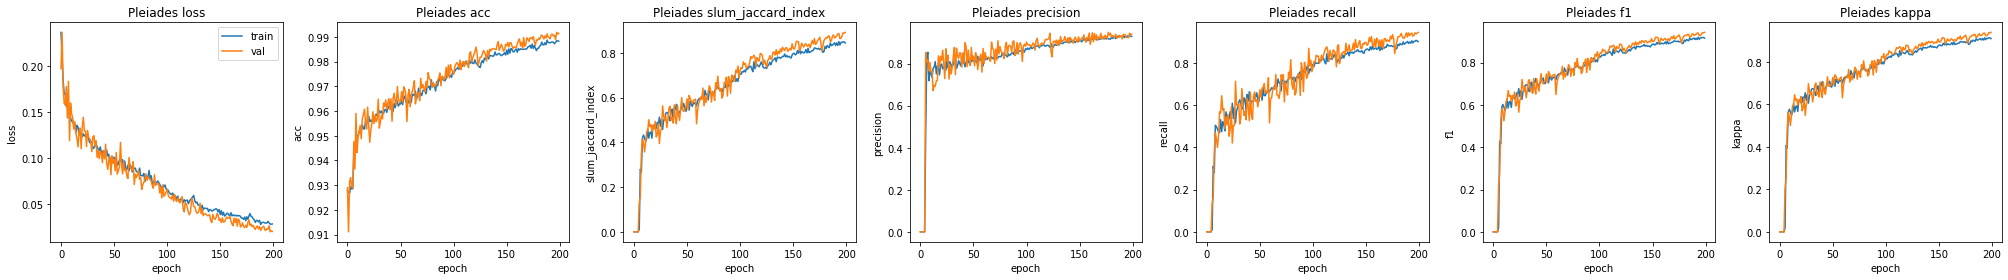

In [59]:
plot_all_metrics(dropout_history.history)

In [60]:
data_viz = iter(data.batch(1))

In [62]:
## HERE WE CHECK THAT THE DIFFERENT MODELS WITH DROPOUT REALLY DO GIVE DIFFERENT PREDS WHEN WE FORCE DROPOUT AT TEST TIME
### using https://stackoverflow.com/questions/63238203/how-to-get-intermediate-outputs-in-tf-2-3-eager-with-learning-phase

from tensorflow.python.keras.backend import eager_learning_phase_scope

fn = K.function([dropout_model.input], [dropout_model.output])

# run in training mode, i.e. 1 means training
with eager_learning_phase_scope(value=1):
    for _ in range(5):
        print(np.array(fn([data_point[0]]))[0,0,:5,:5,0])

[[0.02732095 0.01919809 0.00597674 0.00559887 0.00580728]
 [0.01945278 0.00814423 0.00626448 0.00815144 0.00708455]
 [0.01512325 0.01317903 0.00787774 0.01202083 0.01847562]
 [0.02031797 0.01462692 0.01201871 0.01605716 0.01976719]
 [0.02176234 0.01393157 0.0080592  0.01700285 0.02513465]]
[[0.09279284 0.04827505 0.02960458 0.03365898 0.04167163]
 [0.04741526 0.02718949 0.03250885 0.02666411 0.03601304]
 [0.01938927 0.01866016 0.03709546 0.02195397 0.03384191]
 [0.01992443 0.01918024 0.01175061 0.0189319  0.0149568 ]
 [0.0222204  0.0243797  0.01473713 0.01912883 0.0202097 ]]
[[0.06572482 0.02103722 0.0105949  0.01269951 0.01353073]
 [0.02649617 0.01285845 0.01053679 0.00935507 0.0210999 ]
 [0.01673773 0.01391765 0.0113695  0.01286924 0.02673528]
 [0.0117965  0.01115984 0.01042229 0.01693583 0.01424199]
 [0.0106377  0.00892046 0.01069504 0.01801121 0.01137206]]
[[0.09233308 0.05572399 0.02516875 0.02215016 0.02083611]
 [0.0519422  0.03052169 0.02468809 0.01437134 0.01487535]
 [0.0572138

In [66]:
## modified pred visualiser to include entropy and MI values
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tensorflow.python.keras.backend import eager_learning_phase_scope
import tensorflow.keras.backend as K


def bayesian_pred_visualiser(iter_dataset, num_tiles, bayesian_model, n_models = 100, data_type="VHR"):    
    for i in range(num_tiles):
        img_tf, trg_tf = next(iter_dataset)
        img, trg, = img_tf.numpy(), trg_tf.numpy()
        pred_fn = K.function([bayesian_model.input], [bayesian_model.output])
        with eager_learning_phase_scope(value=1):
            all_preds = np.array([pred_fn([img]) for _ in range(n_models)])
        overall_pred_ = np.mean(all_preds, axis=0)
        overall_pred = filter_pred(overall_pred_)
        mut_inf = mutual_info(all_preds) ## captures epistemic uncertainty
        pred_ent = predictive_entropy(all_preds) ## captures epistemic uncertainty
        if data_type == "VHR":
            fig, ax = plt.subplots(1,5, figsize=(20, 4))
            ax[0].set_title("Image")
            ax[1].set_title("Truth")
            ax[2].set_title("Bayesian UNet Prediction")
            ax[3].set_title("Pred_Ent (Epi+Alea)")
            ax[4].set_title("Mut_Info (Epi Only)")

            ax[0].imshow(img.astype(np.uint8)[0,:,:,:])
            ax[1].imshow(trg.astype(np.uint8)[0,:,:])
            ax[2].imshow(overall_pred.astype(np.uint8)[0,0,:,:,0])

            divider3 = make_axes_locatable(ax[3])
            cax3 = divider3.append_axes('right', size='5%', pad=0.1)
            im3 = ax[3].imshow(pred_ent[0,0,:,:,0])
            fig.colorbar(im3, cax=cax3, orientation='vertical')

            divider4 = make_axes_locatable(ax[4])
            cax4 = divider4.append_axes('right', size='5%', pad=0.1)
            im4 = ax[4].imshow(mut_inf[0,0,:,:,0])
            fig.colorbar(im4, cax=cax4, orientation='vertical')


            ax[0].set_xticks([], [])
            ax[1].set_xticks([], [])
            ax[2].set_xticks([], [])
            ax[3].set_xticks([], [])
            ax[4].set_xticks([], [])
            ax[0].set_yticks([], [])
            ax[1].set_yticks([], [])
            ax[2].set_yticks([], [])
            ax[3].set_yticks([], [])
            ax[4].set_yticks([], [])
            
        elif data_type == "LR":
            fig, ax = plt.subplots(1,4, figsize=(16, 4))
            ax[0].set_title("Truth")
            ax[1].set_title("Bayesian UNet Prediction")
            ax[2].set_title("Pred_Ent (Epi+Alea)")
            ax[3].set_title("Mut_Info (Epi Only)")

            ax[0].imshow(trg.astype(np.uint8)[0,:,:])
            ax[1].imshow(overall_pred.astype(np.uint8)[0,0,:,:,0])

            divider2 = make_axes_locatable(ax[2])
            cax2 = divider2.append_axes('right', size='5%', pad=0)
            im2 = ax[2].imshow(pred_ent[0,0,:,:,0])
            fig.colorbar(im2, cax=cax2, orientation='vertical')

            divider3 = make_axes_locatable(ax[3])
            cax3 = divider3.append_axes('right', size='5%', pad=0)
            im3 = ax[3].imshow(mut_inf[0,0,:,:,0])
            fig.colorbar(im3, cax=cax3, orientation='vertical')


            ax[0].set_xticks([], [])
            ax[1].set_xticks([], [])
            ax[2].set_xticks([], [])
            ax[3].set_xticks([], [])
            ax[0].set_yticks([], [])
            ax[1].set_yticks([], [])
            ax[2].set_yticks([], [])
            ax[3].set_yticks([], [])
            
            
            
        fig.tight_layout()    
        plt.show()

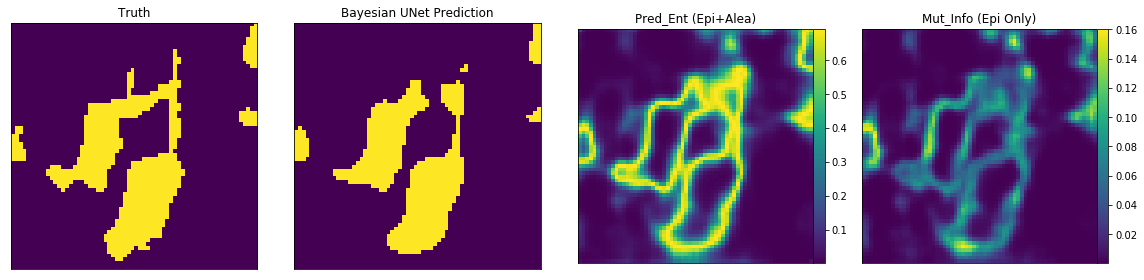

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


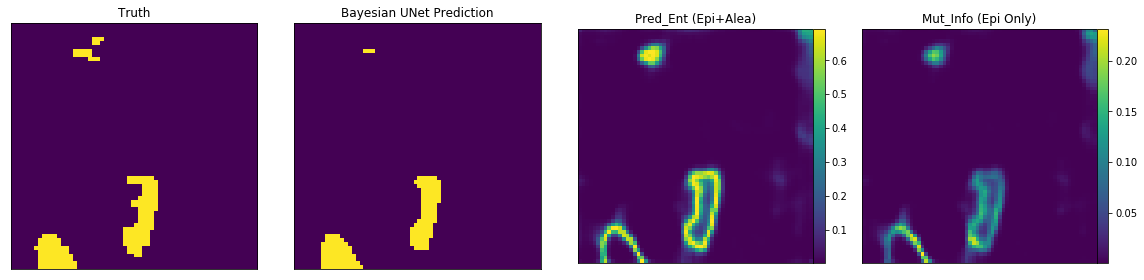

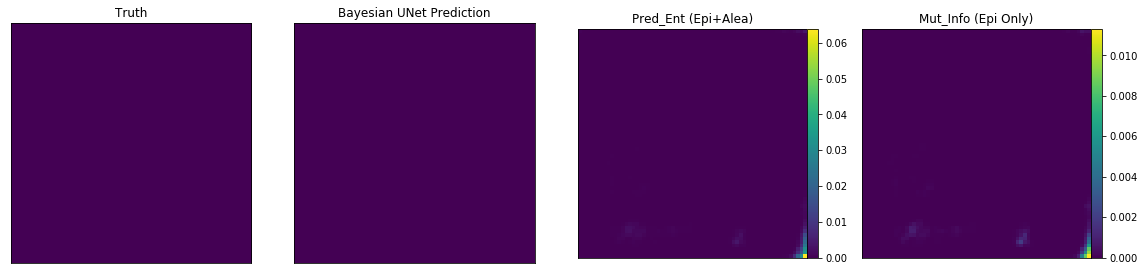

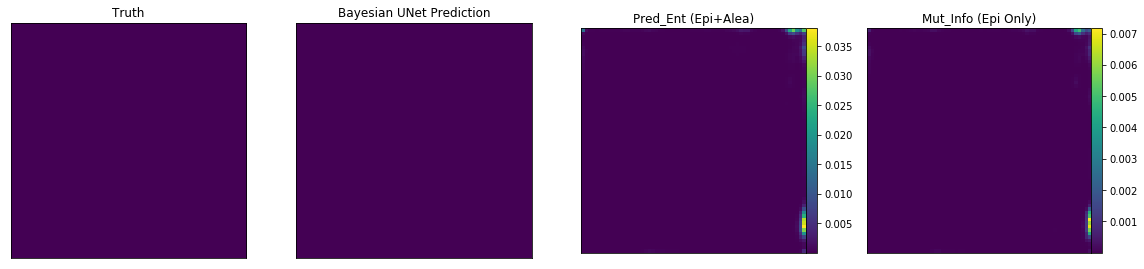

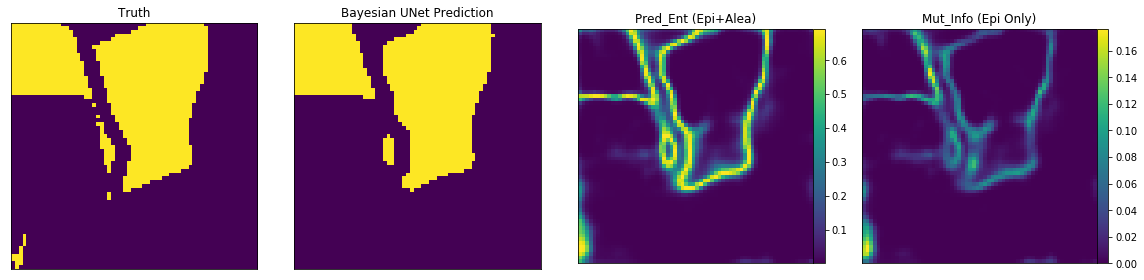

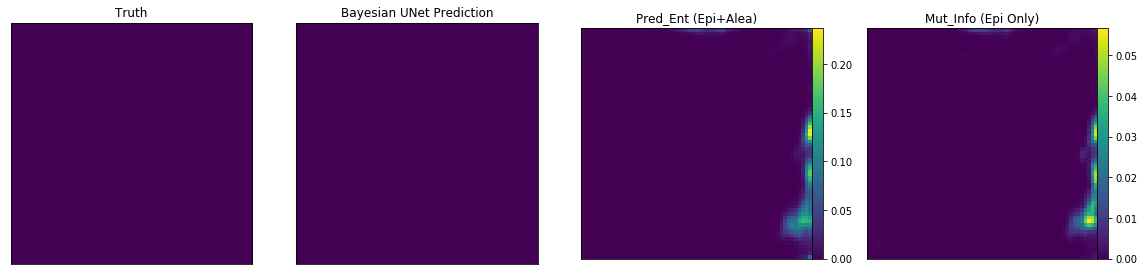

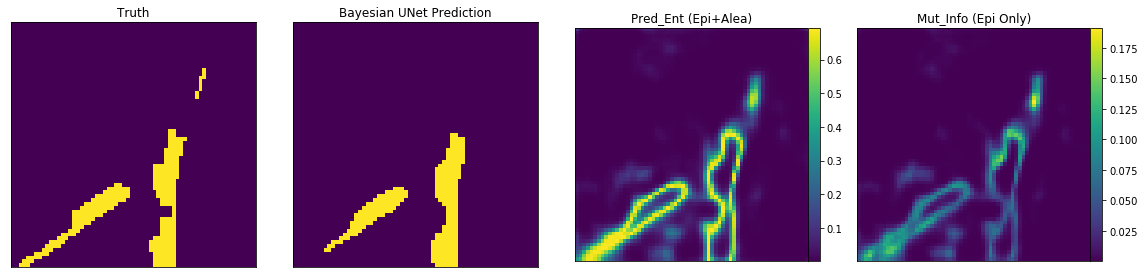

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  


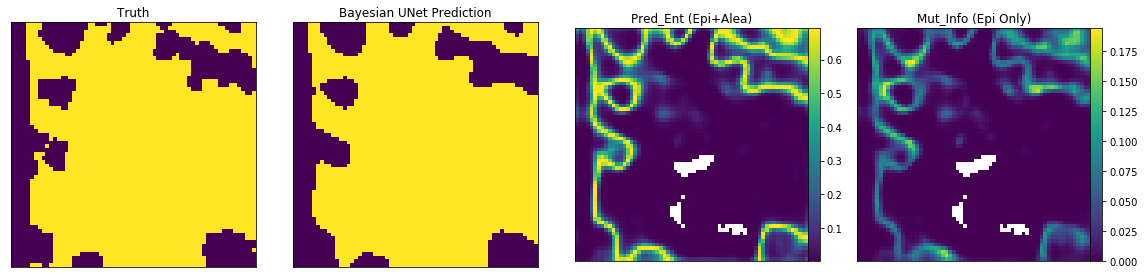

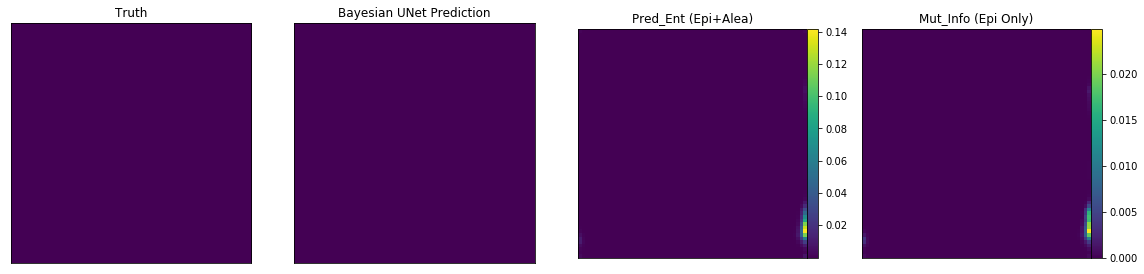

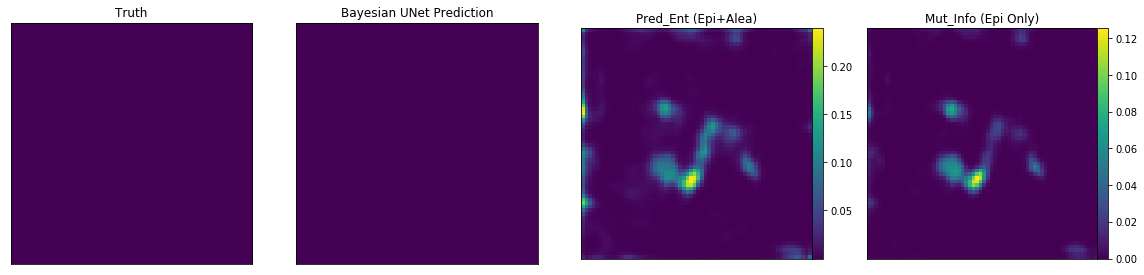

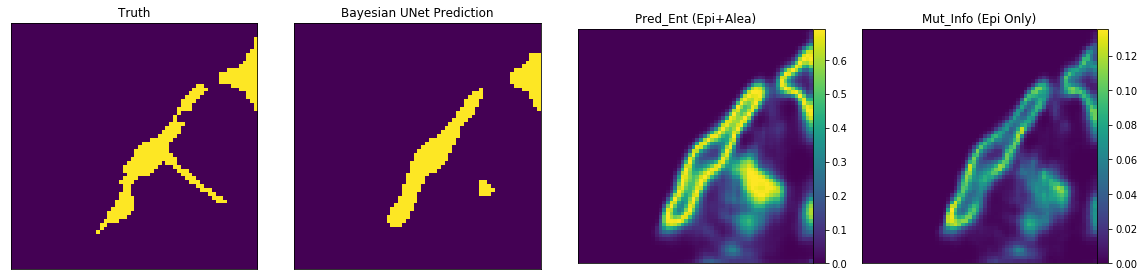

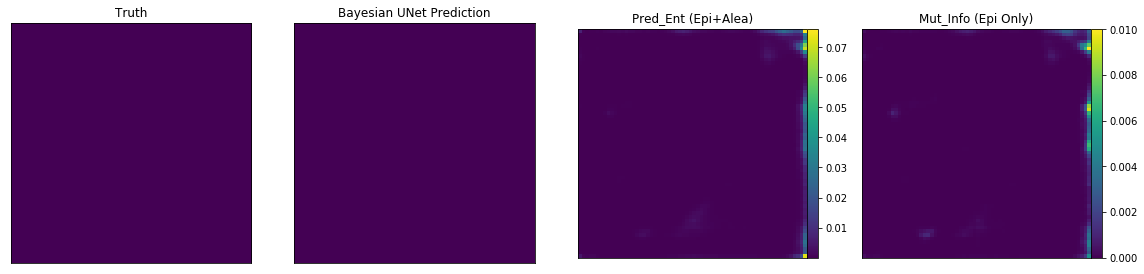

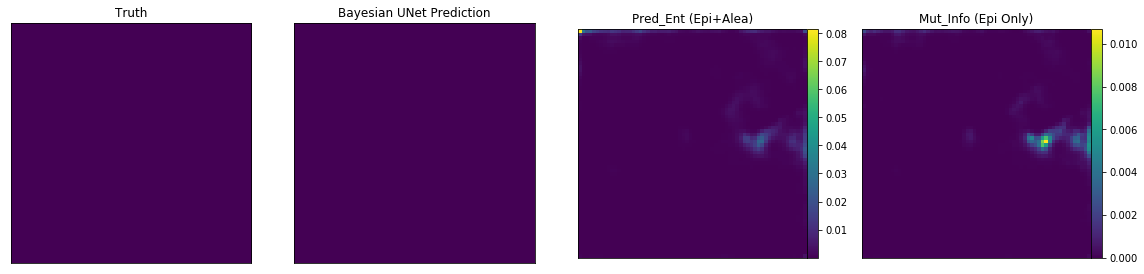

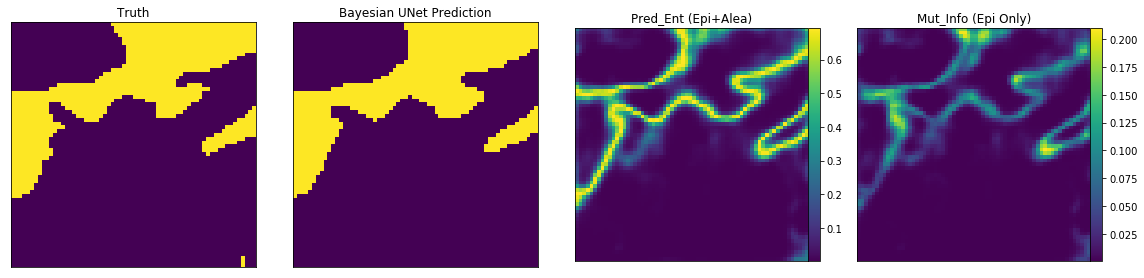

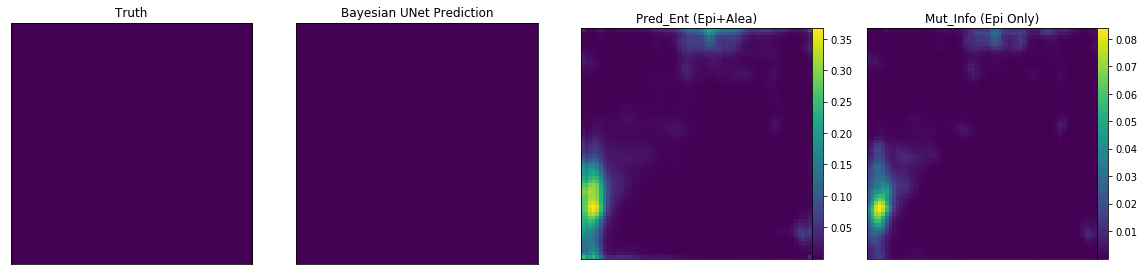

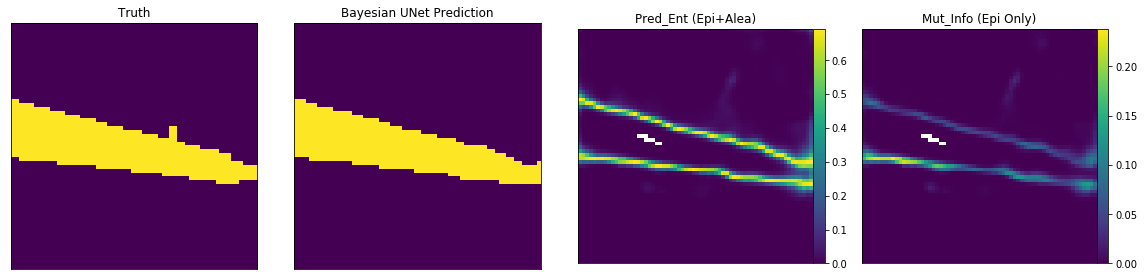

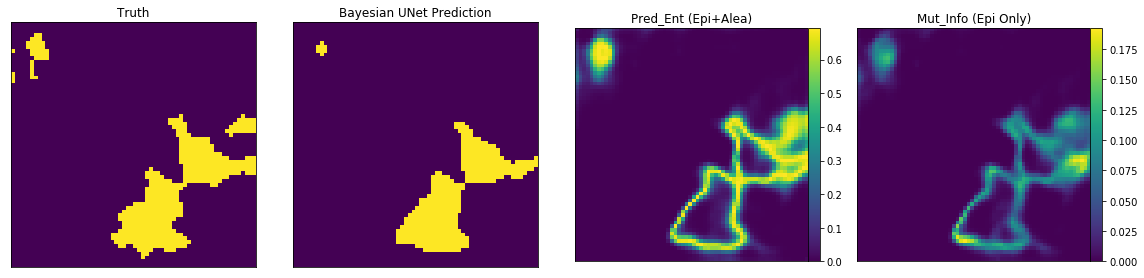

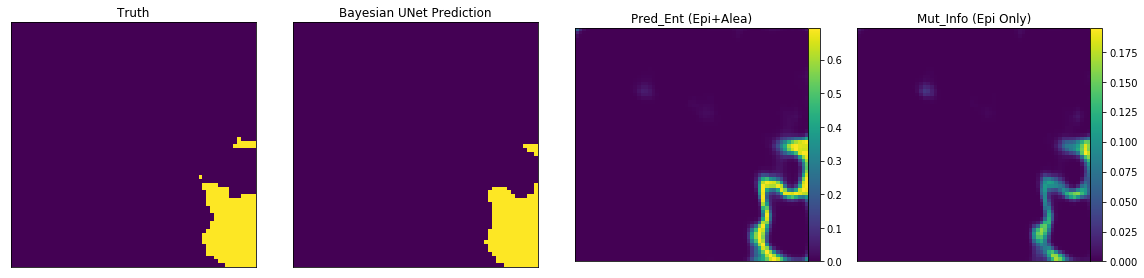

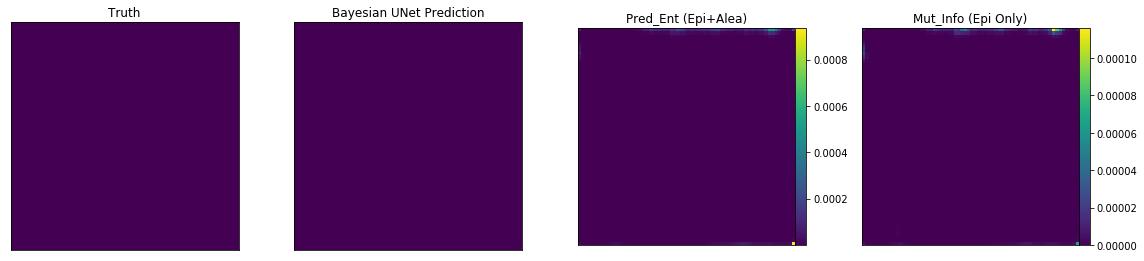

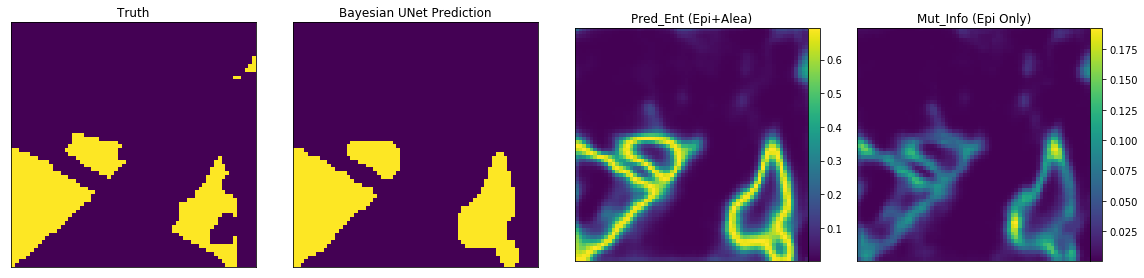

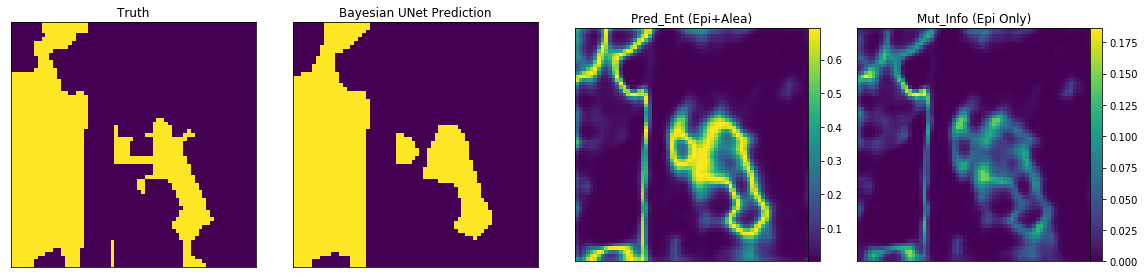

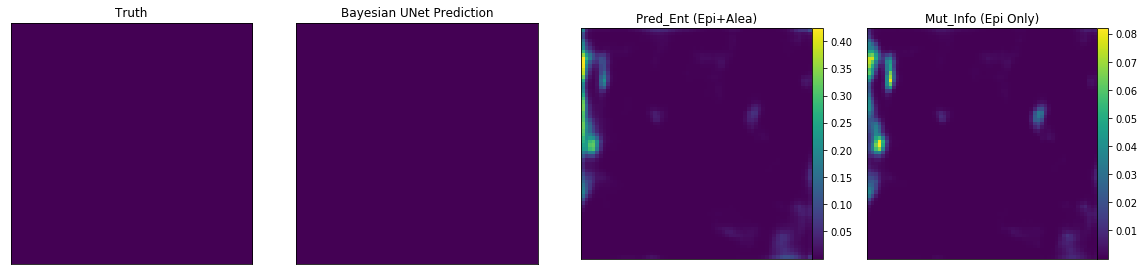

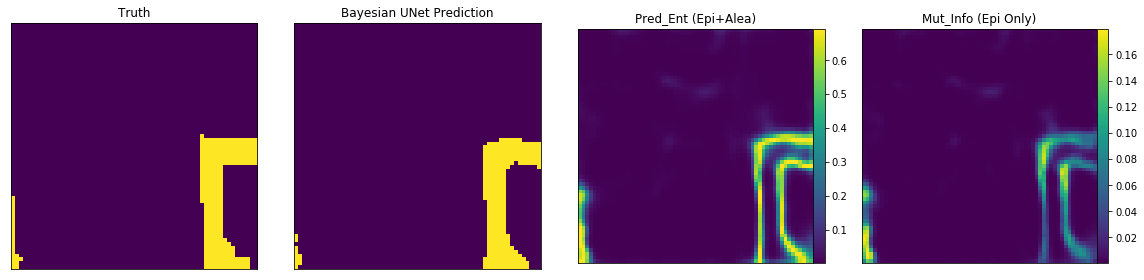

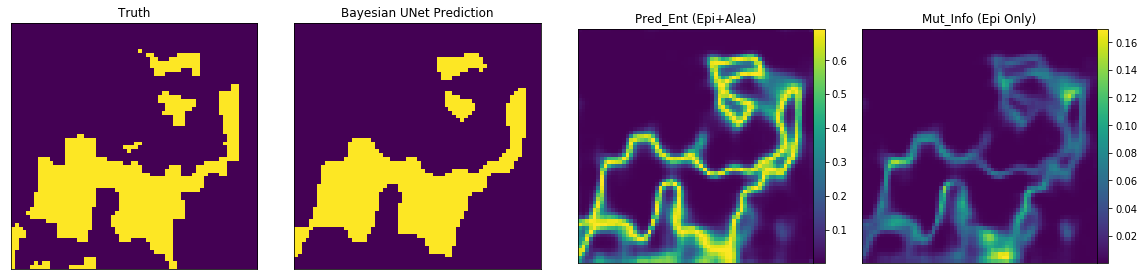

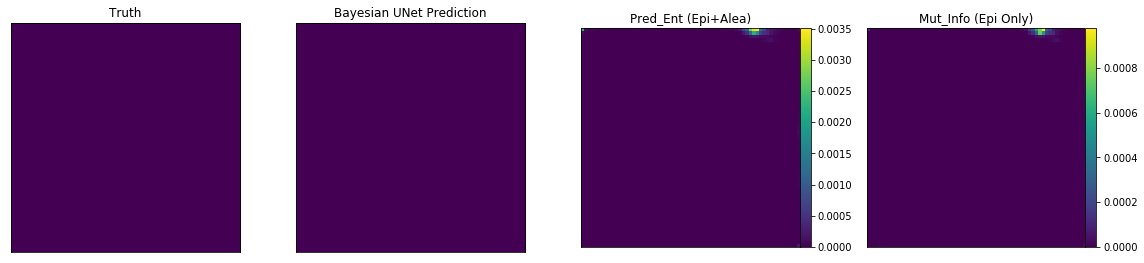

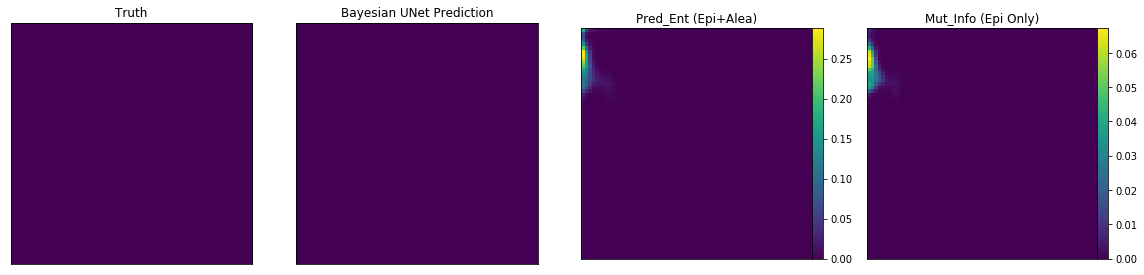

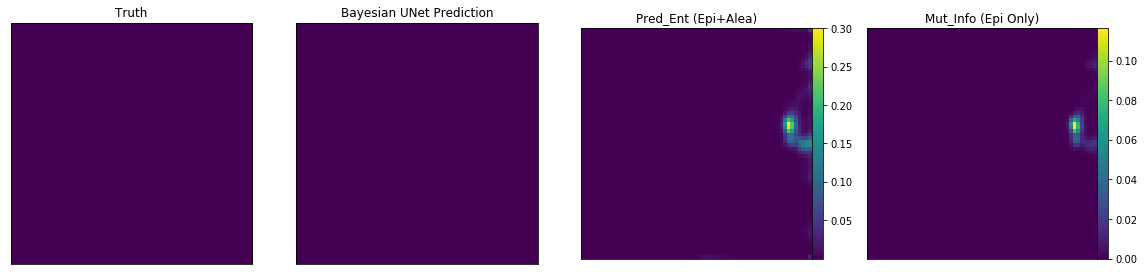

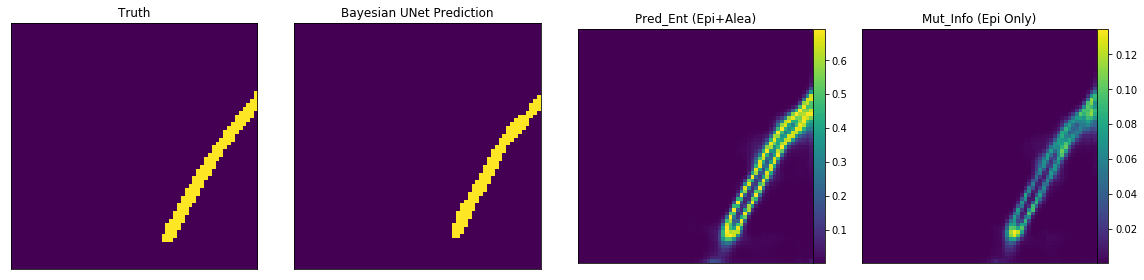

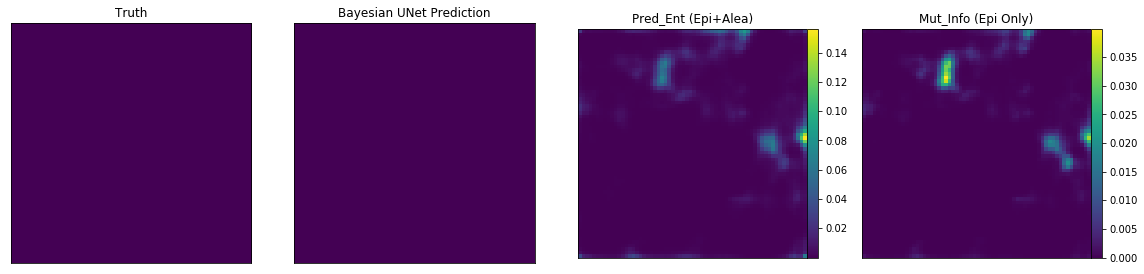

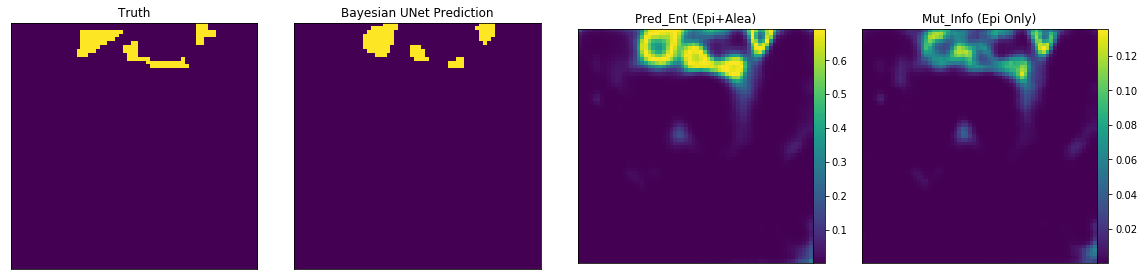

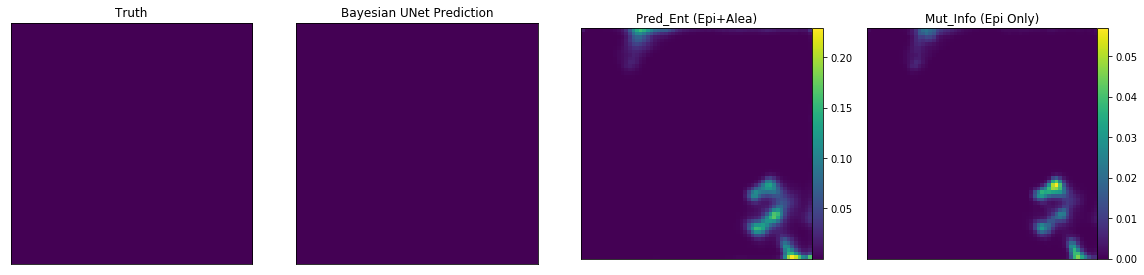

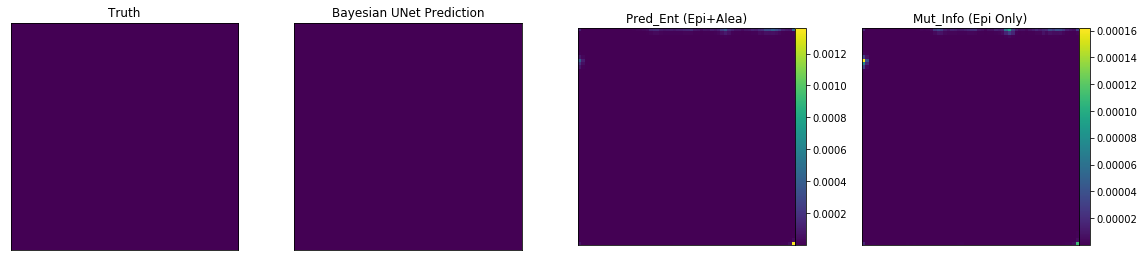

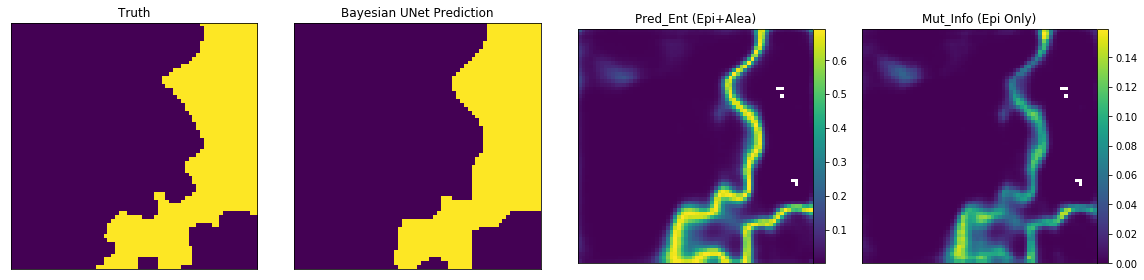

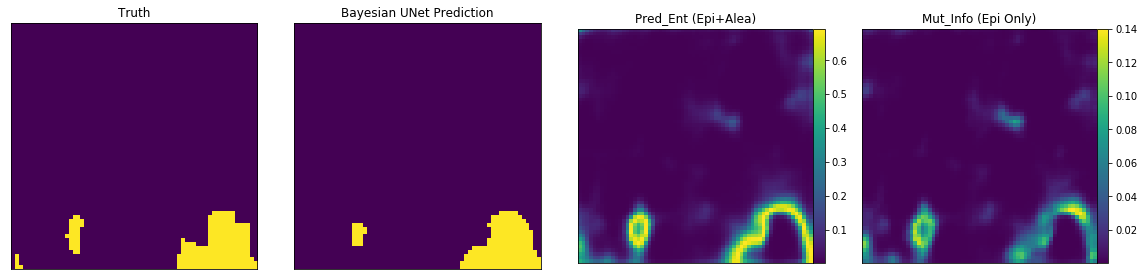

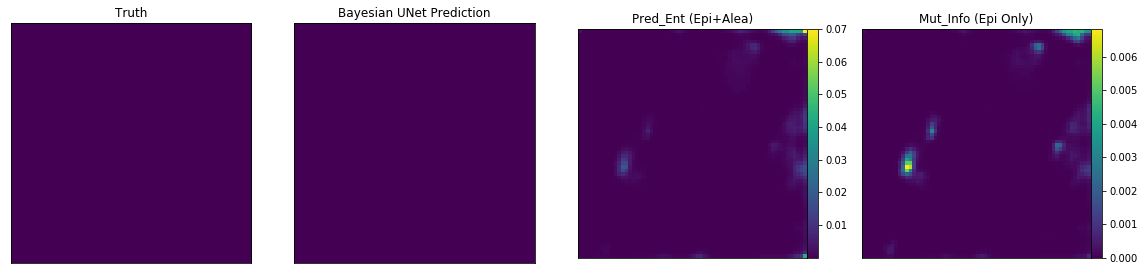

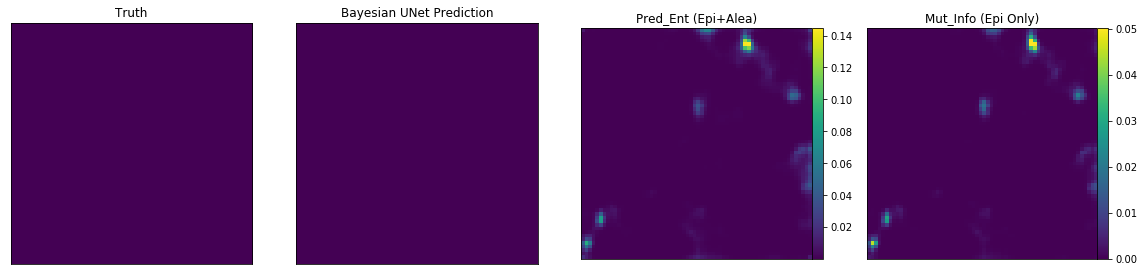

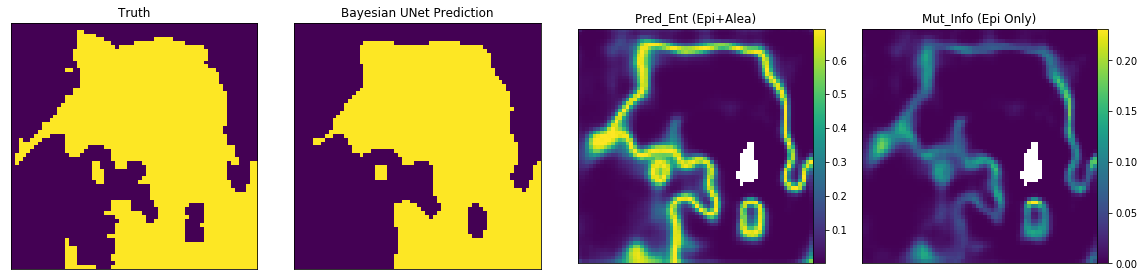

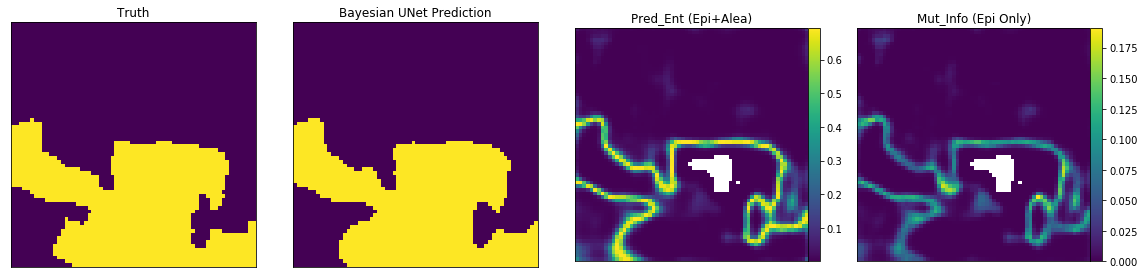

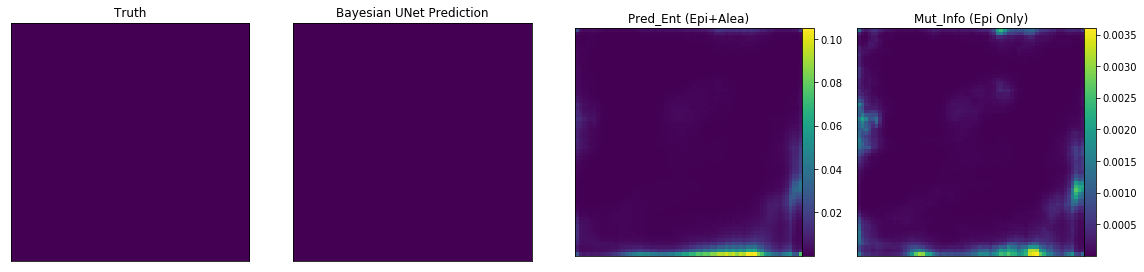

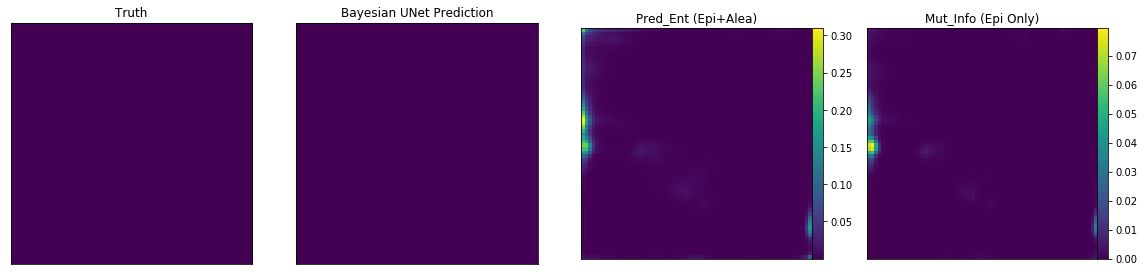

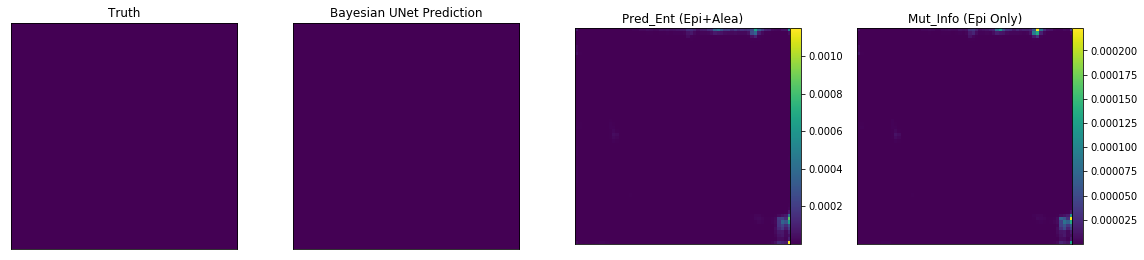

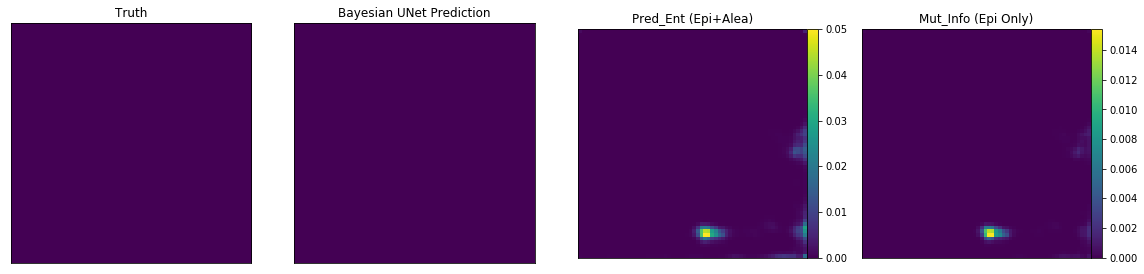

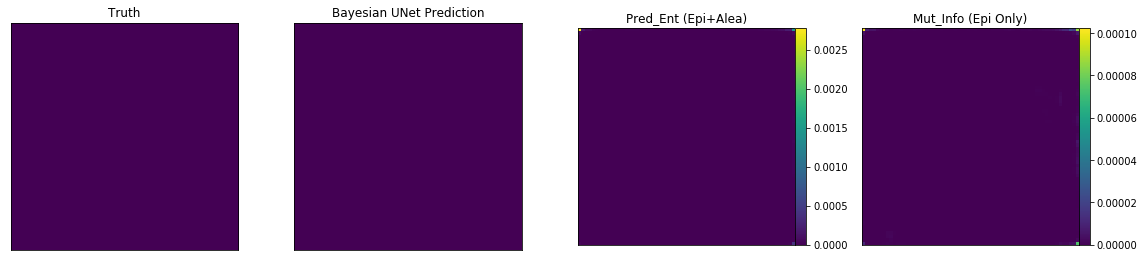

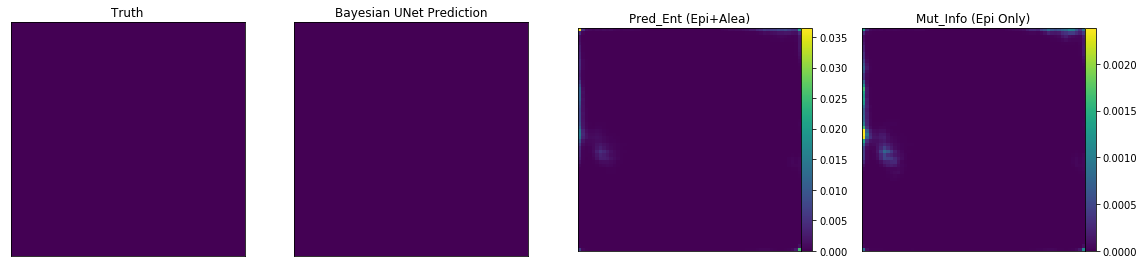

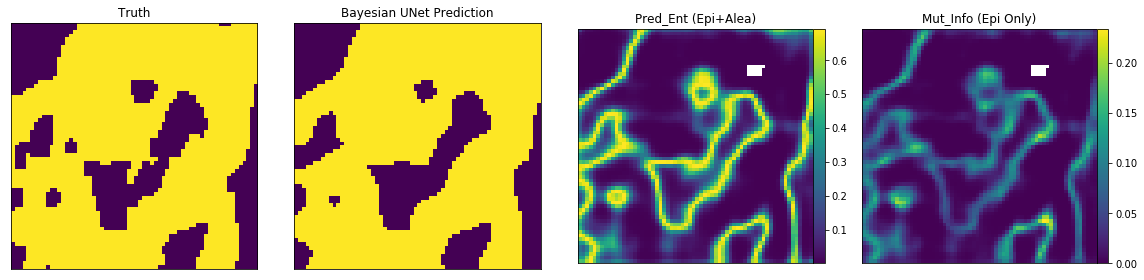

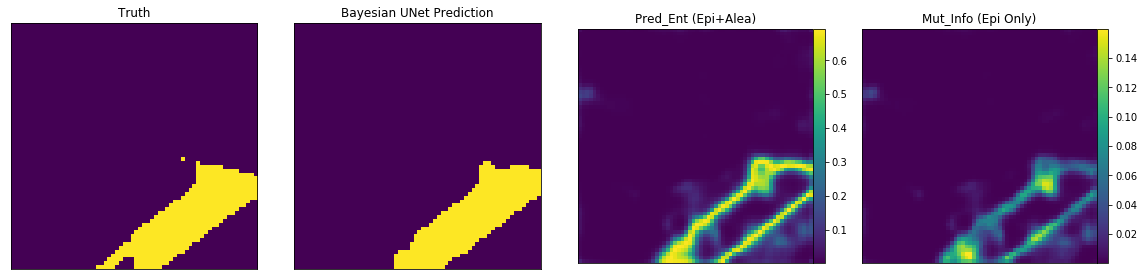

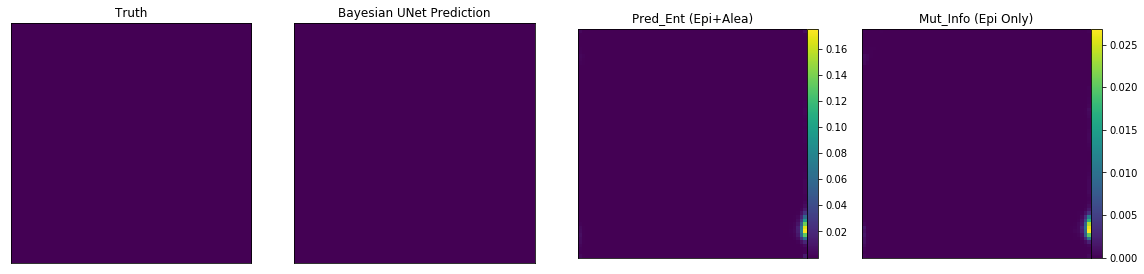

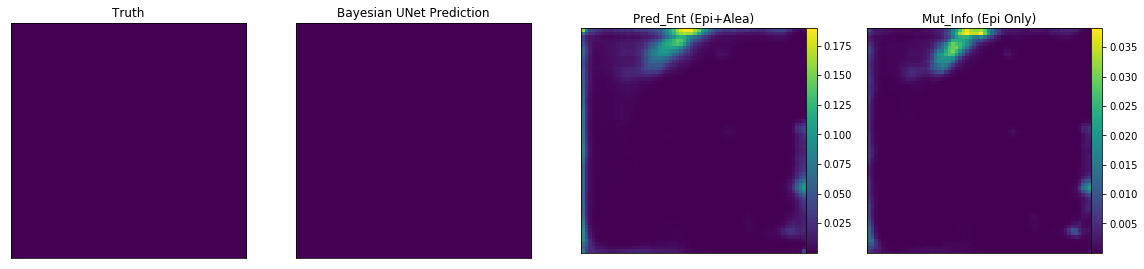

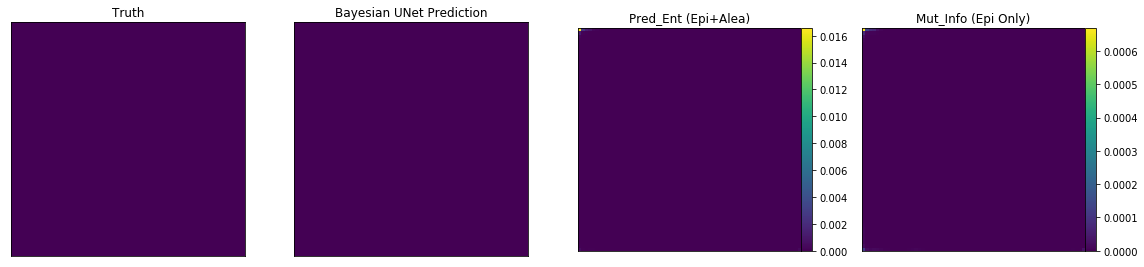

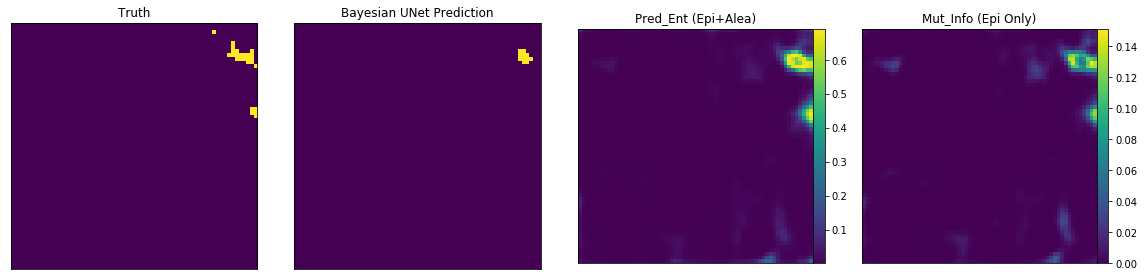

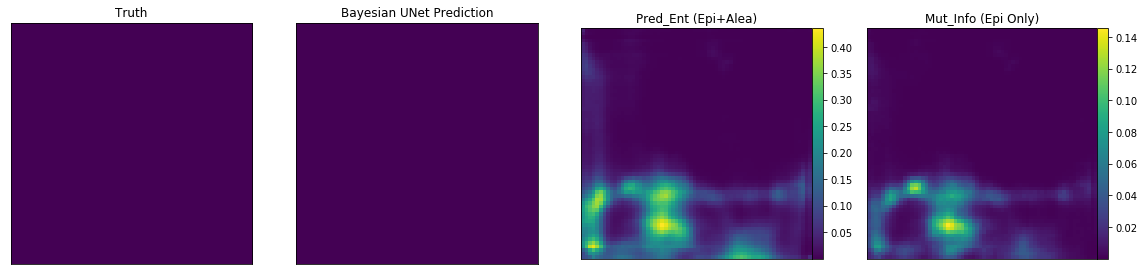

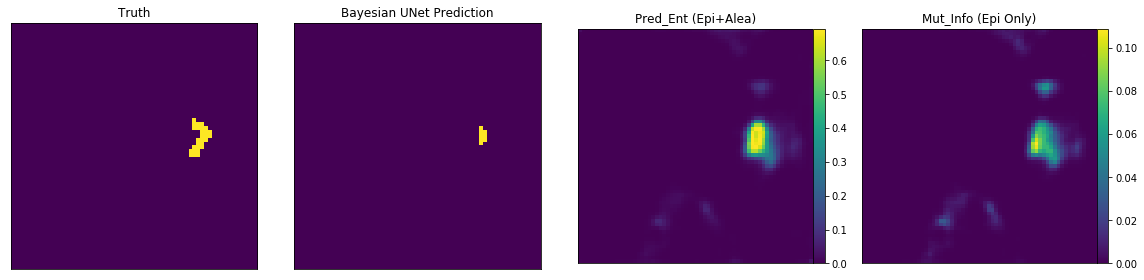

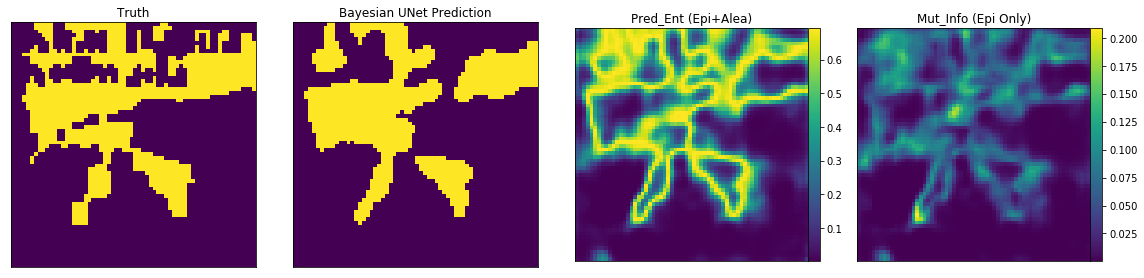

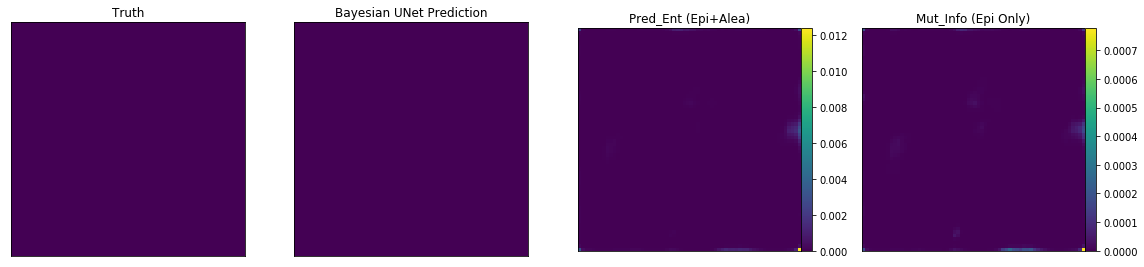

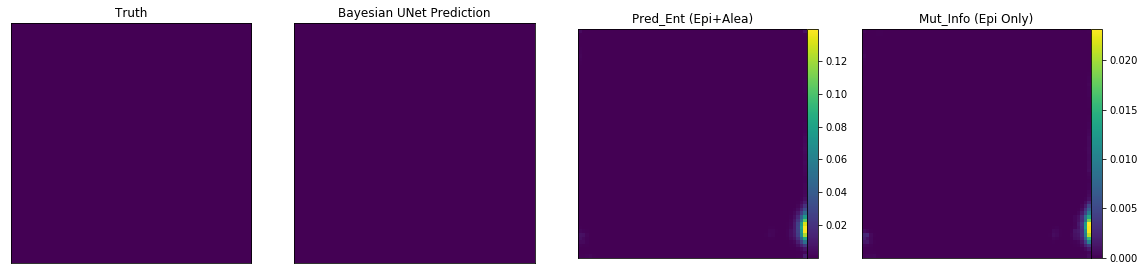

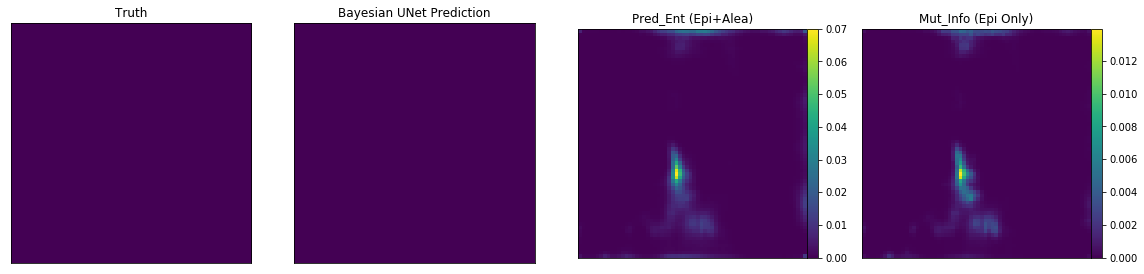

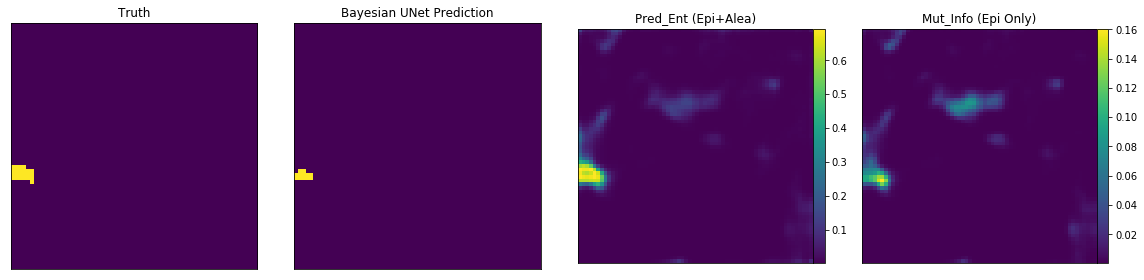

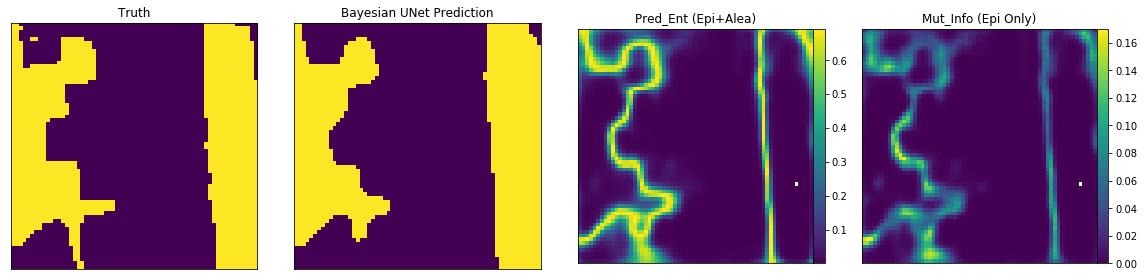

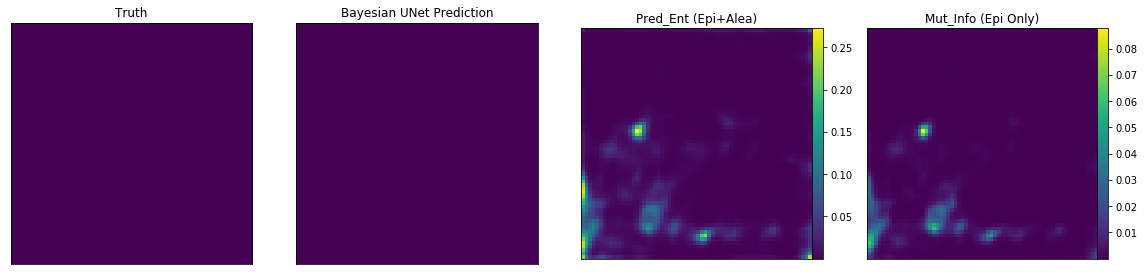

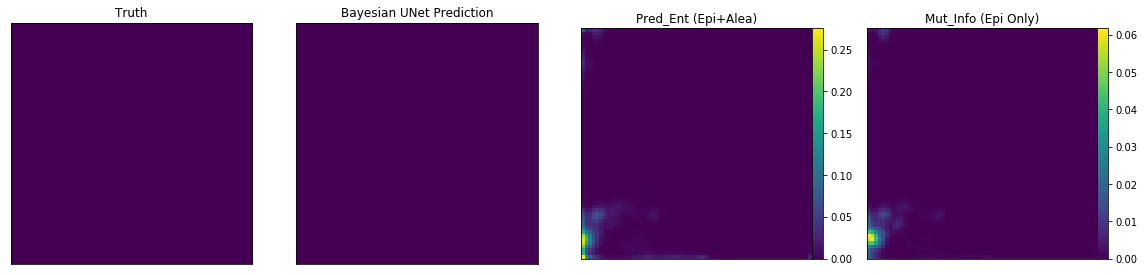

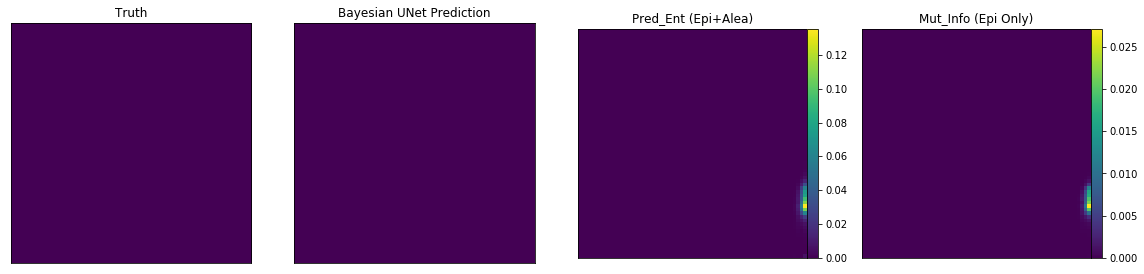

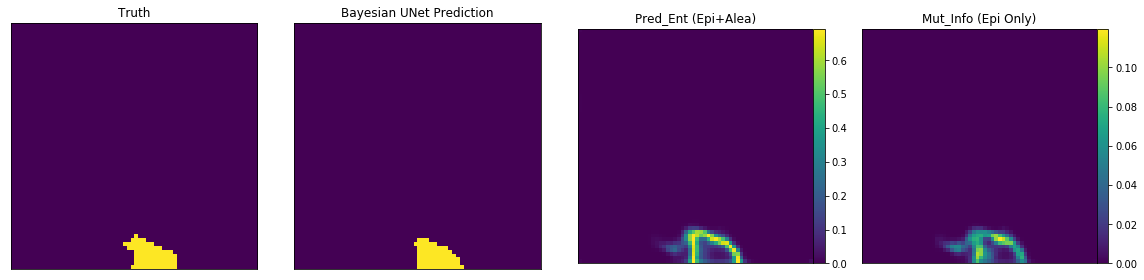

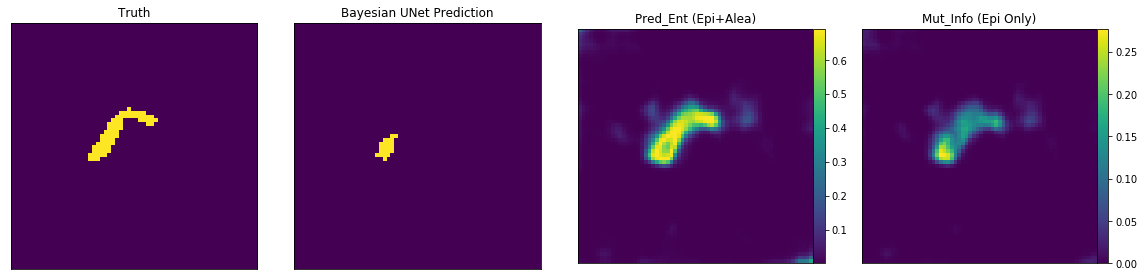

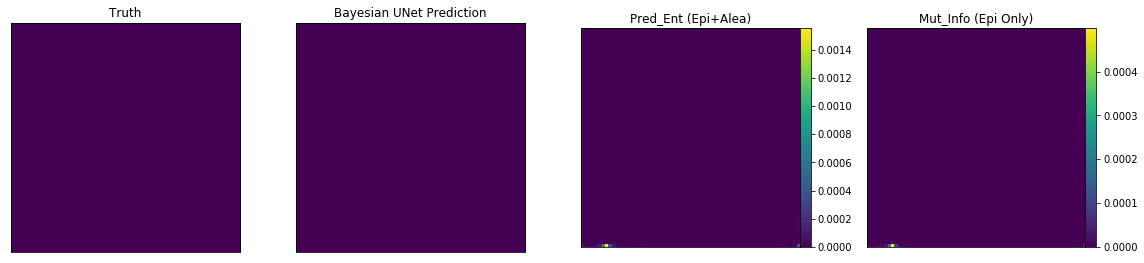

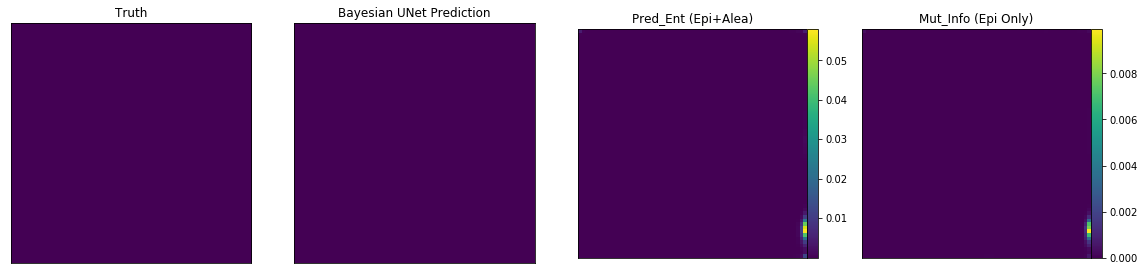

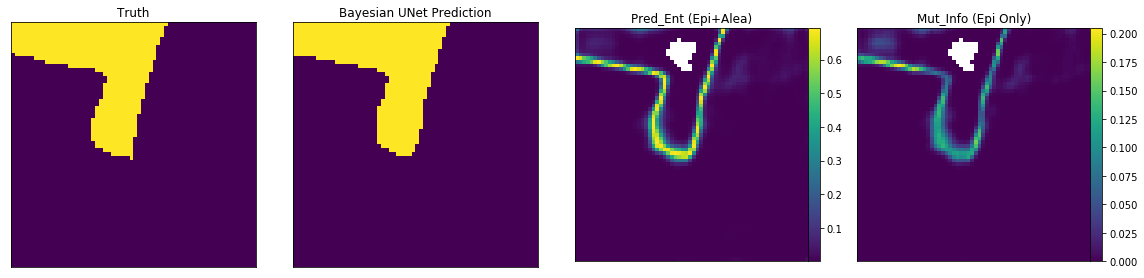

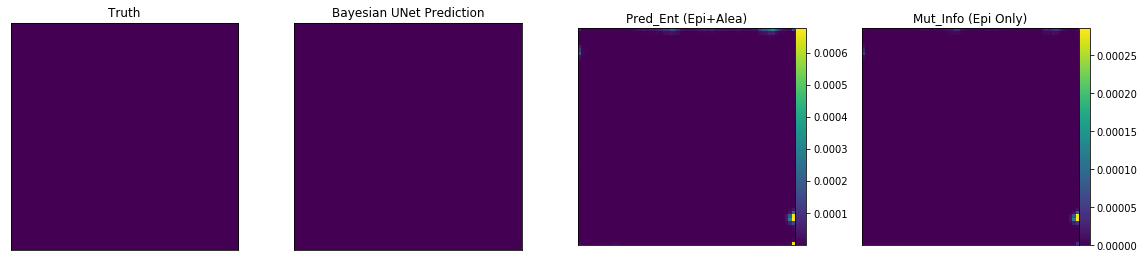

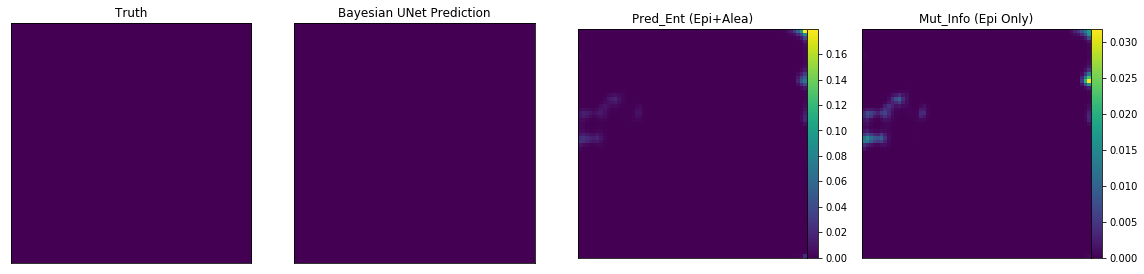

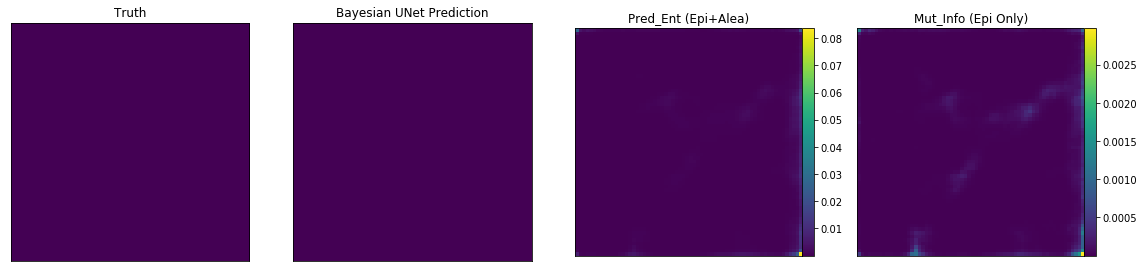

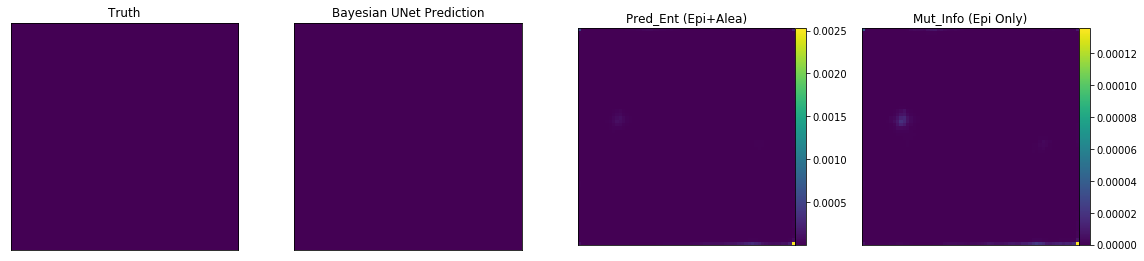

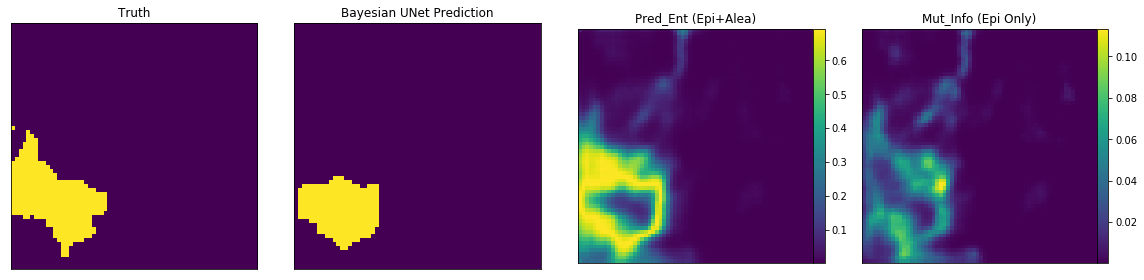

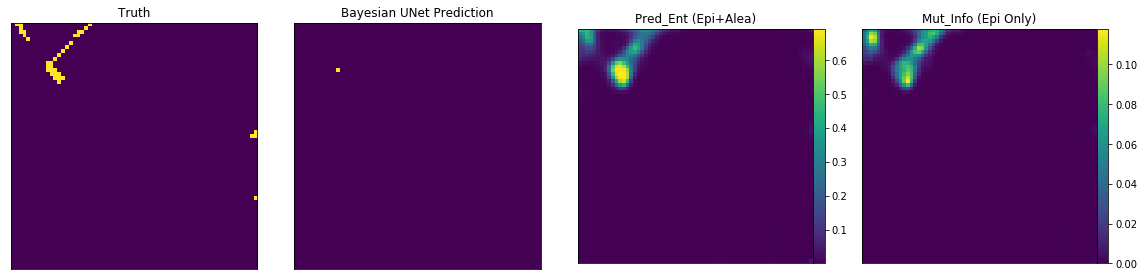

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


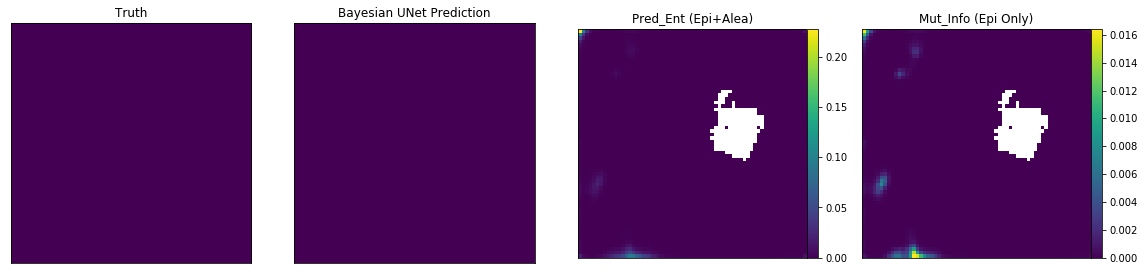

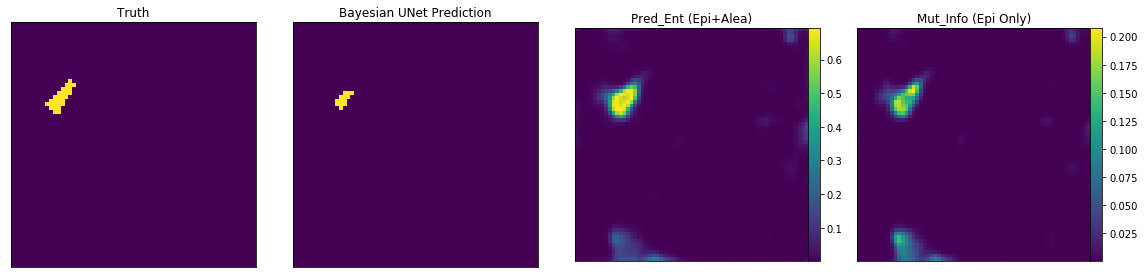

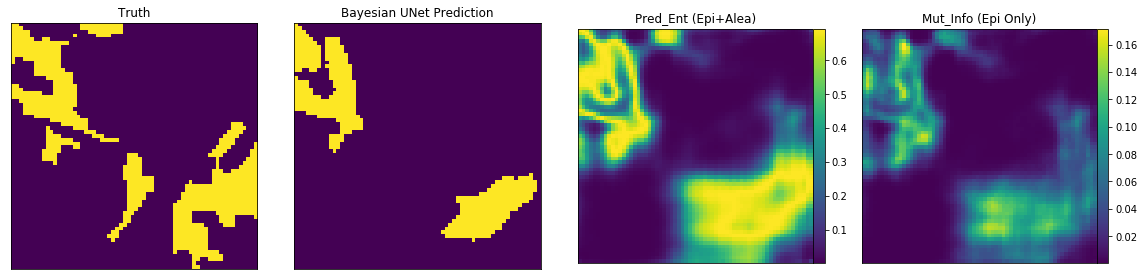

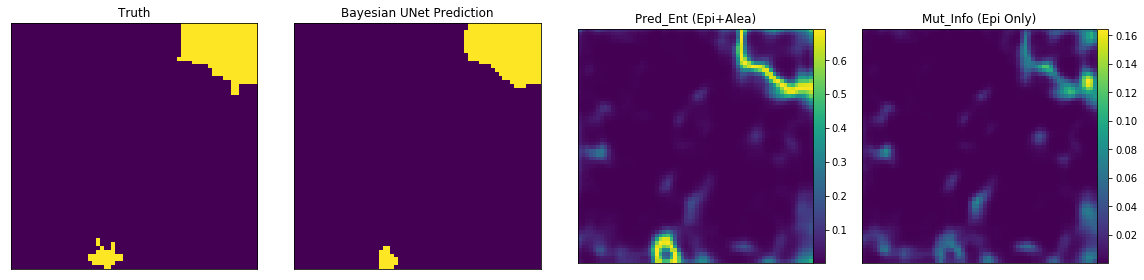

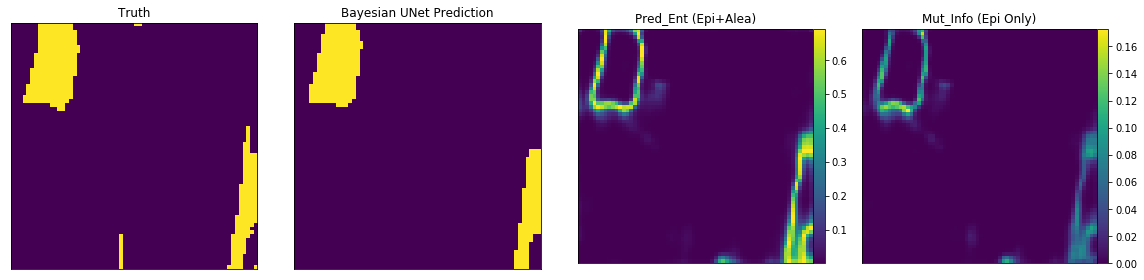

KeyboardInterrupt: 

In [67]:
bayesian_pred_visualiser(data_viz,100,dropout_model,n_models = 100, data_type="LR")